

<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>


## Non-linear Dimensionality Reduction Visualization and Comparisons: Kernel PCA, ISOMAP, T-SNE and UMAP

#### Feiyue Xia
#### Hildbrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Misael Morales, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/misaelmmorales)


***

### Executive Summary
Real datasets, such as images and subsurface geostatical data, usually have large data volume and high dimensions which are difficult to handle with in machine learning workflows. Dimensionality reduction aims to reduce variables while maintaining mian feautres of data. It can not only improve performance of machine learning through decreasing training time and computational resources, but also avoid overfitting.

We have learned Principal Components Analysis(PCA), Multidimensional Scaling(MDS) and Random Projections in the Subsurface Machine Learning class. Here, we focus on other non-linear dimensionality reduction methods ( **Kernel PCA**, **t-distributed Stochastic Neighbor Embedding (t-SNE)**, **Isometric mapping (Isomap)**, **Uniform Manifold Approximation and Projection (UMAP)**) which are not covered in the class. Images from MINST are used to demonstrate these non-linear dimensionality reduction methods through visualizing reduced data in interactive 3 dimensional plot. Finally, **Support Vector Machine (SVM)** is applied to demonstrate the efficiency of above non-linear methods by comparing  predicted accuracy with traidtional PCA.

In the 3D visualization of reduced data, some clear boundaries between different digits can be seen in the isomap, t-SNE and UMAP. Kernel PCA have similar reults as PCA.Kernel PCA cannot handle very high dimensional data with non-linear relationship. UMAP clusters the different digits quite nicely, similar to or better than t-SNE. UMAP is much faster than t-SNE. In contrast to t-SNE, UMAP does not need any Dimensionality Reduction preprocessing to perform. If data dimensions are over 50, one should do PCA to reduce data dimensions lower than 50 before conducting t-SNE. In the SVM models, reduced data of t-SNE and UMAP brings the highest classification accuracy which is approximately close to the accuracy of full dimensional data training model.Therefore, UMAP is highly recommended for dimensionality reduction.

***

### Table of Contents
1. Import Packages </br>
2. Define functions </br>
3. Load & Preprocess Data </br>
    a) MNIST Data </br>
4. None-linear Dimensionality Reduction </br>
    a) Principal Components Analysis (PCA, linear method for the comparison) </br>
    b) Kernel Principal Components Analysis (Kernel PCA) </br>
    c) Isometric mapping (Isomap) </br>
    d) T-distributed Stochastic Neighbor Embedding (t-SNE) </br>
    e) Uniform Manifold Approximation and Projection (UMAP)
5. Methods Comparisons using Support Vector Machine(SVM)

***

### 1. Import Packages

Import basic packages for data manipulation and plot

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px # for interactive 3D data visualization
import umap # for UMAP dimensionality redction install here https://github.com/lmcinnes/umap.

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

SystemError: execution of module netCDF4._netCDF4 raised unreported exception

Import other important functions for preprocessing, metrics and non-linear dimensionality reduction

In [2]:
from keras.datasets import mnist #MNIST data
from time import time
import matplotlib.pyplot as plt # for plotting
from sklearn.svm import SVC # Support Vector Machine
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA # for PCA dimensionality reduction
from sklearn.pipeline import Pipeline 
from sklearn.manifold import TSNE # for t-SNE dimensionality reduction
from sklearn.manifold import Isomap # for Isomap dimensionality reduction
from sklearn.decomposition import KernelPCA # for Kernel PCA dimensionality reduction

### 2. Define functions
We define functions here that will be frequently used in the notebook.
- Function **data_visualize** is used to visualize 3 dimensional data in a interactive plot
- Function **SVM_accuracy** is used to train a Support Vector Machine (SVM) and return predicted accuracy between testing data and predicted data 

In [3]:
# Plot function for sample images
def data_visualize(results,y):
    fig = px.scatter_3d(None, 
                    x=results[:,0], y=results[:,1], z=results[:,2],
                    color=y.astype(str),
                    height=900, width=900
                   )

    # Update chart looks
    fig.update_layout(title_text="Scatter 3D Plot",
                      showlegend=True,
                      legend=dict(orientation="h", yanchor="top", y=0.9, xanchor="center", x=0.5),
                      scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                            center=dict(x=0, y=0, z=-0.2),
                                            eye=dict(x=-1.5, y=1.5, z=0.5)),
                                            margin=dict(l=0, r=0, b=0, t=0),
                      scene = dict(xaxis=dict(backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=14),
                                              tickfont=dict(size=14),
                                             ),
                                   yaxis=dict(backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=14),
                                              tickfont=dict(size=14),
                                              ),
                                   zaxis=dict(backgroundcolor='lightgrey',
                                              color='black', 
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=14),
                                              tickfont=dict(size=14),
                                             )))

    # Update marker size
    fig.update_traces(marker=dict(size=4))

    fig.show()

In [4]:
def SVM_accuracy(x_train,y_train,x_test,y_test,class_names):
    # Define SVM function
    model = SVC(kernel = 'rbf',class_weight = 'balanced')
    
    # Train
    t0 = time()
    model.fit(x_train, y_train)

    # Predict
    y_pred = model.predict(x_test)
    
    # print SVM training report and return accuracy
    dictionary = classification_report(y_test,y_pred,target_names = class_names,output_dict = True)
    print(classification_report(y_test,y_pred,target_names = class_names))
   
    #Training time display
    t_reduced_feats = time() - t0
    print("Training and classification done in {}s".format(t_reduced_feats))
    return dictionary['accuracy'],t_reduced_feats

### 2. Load & Preprocess Data

We will deal with MNIST dataset: handwritten digits as $28x28$ images from *tensorflow* (Version 2.9.1).
This is a set of $60,000$ images of handwritten digits $0$-$9$. We load it directly from *tensorflow* datasets ([link](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist))

In [5]:
# Load mnist dataset and split into training/testing
(x_trainO, y_trainO), (x_testO, y_testO) = mnist.load_data()
print('Original data')
print('Training data with full siz Shape: X={}, Y={}'.format(x_trainO.shape, y_trainO.shape))
print('Testing data with full size Shape: X={}, Y={}\n'.format(x_testO.shape, y_testO.shape))

# Choose N images to work with
N = 3000
x_train, x_test = x_trainO[:2*N], x_testO[:N]
y_train, y_test = y_trainO[:2*N], y_testO[:N]


# Reshape and normalize the 28x28 pixel images into a single 784 px vector using .reshape
x_train = np.reshape(x_train, (len(x_train), -1))/255
x_test = np.reshape(x_test, (len(x_test), -1))/255

x = np.vstack((x_train,x_test))
y = np.hstack((y_train,y_test))
# Define the labels
class_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
print('Data after choosing {} images'.format(N*3))
print('Training data: X={}, Y={} | min={}, max={}'.format(x_train.shape, y_train.shape, x_train.min(), x_train.max()))
print('Testing data: X={}, Y={} | min={}, max={}'.format(x_test.shape, y_test.shape, x_test.min(), x_test.max()))

11501568/11490434 [==============================] - 1s 0us/step
Original data
Training data with full siz Shape: X=(60000, 28, 28), Y=(60000,)
Testing data with full size Shape: X=(10000, 28, 28), Y=(10000,)

Data after choosing 9000 images
Training data: X=(6000, 784), Y=(6000,) | min=0.0, max=1.0
Testing data: X=(3000, 784), Y=(3000,) | min=0.0, max=1.0


In [6]:
# Count the number of occurrences for each digit within the training/testing datasets
digit_count = {}
for i in np.arange(len(class_names)):
    digit_count[i] = x_train[y_train==i].shape[0]
digit_count = pd.DataFrame(list(digit_count.values()), columns=['Count']).T
print('Count Digits in Traning Data:')
digit_count.head()

Count Digits in Traning Data:


,0,1,2,3,4,5,6,7,8,9
Count,592,671,581,608,623,514,608,651,551,601


In [7]:
digit_count = {}
for i in np.arange(len(class_names)):
    digit_count[i] = x_test[y_test==i].shape[0]
digit_count = pd.DataFrame(list(digit_count.values()), columns=['Count']).T
print('Count Digits in Testing Data:')
digit_count.head()

Count Digits in Testing Data:


,0,1,2,3,4,5,6,7,8,9
Count,271,340,313,316,318,283,272,306,286,295


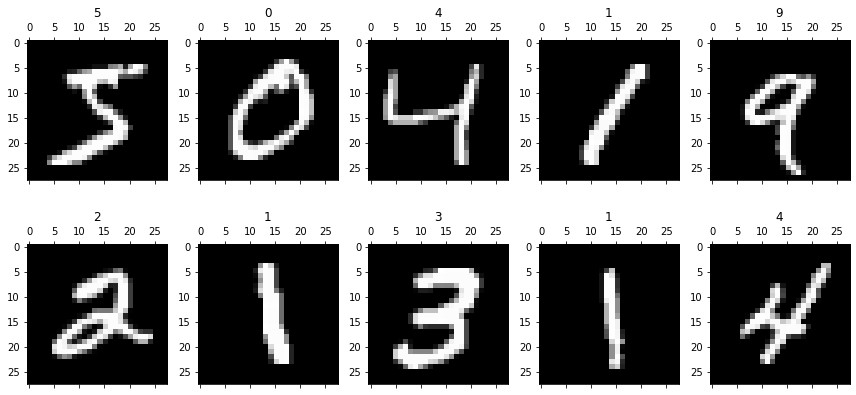

In [8]:
# Display images of the first 10 graphs
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
plt.gray() 
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(x_train[n].reshape(28,28))
        axs[i,j].set(title=y_train[n])
        n=n+1
plt.show() 

***

### 3. Non-linear Dimensionality Reduction

Dimensionality reduction is a feature projection method that simply refers to the process of reducing the number of attributes in a dataset while keeping as much of the variation in the original dataset as possible. It has following advantages: less training time and less computational resources and increases the overall performance of machine learning algorithms; Useful for data visualization; Avoids the problem of overfitting and so on. It generally can be divided into linear and non-linear methods. **Principal Component Analysis (PCA)** and **Singular Value Decomposition (SVD)** are linear deimensionality reduction methods. **Kernel PCA**, **t-distributed Stochastic Neighbor Embedding (t-SNE)**, **Isometric mapping (Isomap)**, **Uniform Manifold Approximation and Projection (UMAP)** are non-linear dimensionality reduction methods.Linear methods have fast computational speed, but it cannot include non-linear relationships. Although data points are projected into lower dimensions, it still loses interpretability. Therefore, non-linear methods have advantages for classifying data points which are projected to lower dimensional space.Because of this advantages, support vector machines (SVM) can have good predicted accuracy with low-dimensional datas.

MNIST images from *keras* are used to demonstrate non-linear methods through projecting 784 dimensions into 3 dimensions. Through an interactive 3D scattering visualization, data points can be easy to interpret. Finally, we use projected data and original data to train SVM. We can compare accuracies between predicted data and testing data through inputing reduced data (3 dimensions) into  SVM. These reduced datas are from different non-linear methods.

### 3. a) Principal Components Analysis (PCA, linear method)

For comparisons with non-linear methods, PCA is used here. PCA is a linear dimensionality reduction technique (algorithm) that transforms a set of correlated variables (p) into a smaller k (k<p) number of uncorrelated variables called principal components while retaining as much of the variation in the original dataset as possible. Please refer to the [Link](https://www.analyticssteps.com/blogs/introduction-principal-component-analysis-machine-learning) for detials.

In [9]:
%%time
### Step 1 define pipeline steps for PCA
pca_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('dim_reduction', PCA(n_components=3))
])
### Step 2 fit data and transform it
pca_results =  pca_pipeline.fit_transform(x_train)

CPU times: total: 906 ms
Wall time: 263 ms


In [10]:
### Step 3 Create a 3D scatter plot
data_visualize(pca_results,y_train)

NameError: name 'px' is not defined

### 3. b) Kernel Principal Components Analysis (Kernel PCA)

The data is first run through a kernel function and temporarily projects them into a new higher-dimensional feature space where the classes become linearly separable (classes can be divided by drawing a straight line). Then the algorithm uses the normal PCA to project the data back onto a lower-dimensional space. In this way, Kernel PCA transforms non-linear data into a lower-dimensional space of data which can be used with linear classifiers. Refer to [Link](https://www.cs.mcgill.ca/~dprecup/courses/ML/Lectures/ml-lecture13.pdf) for details.

In the Kernel PCA, we need to specify 3 important hyperparameters — the number of components (**n_components**) we want to keep, the type of kernel and the kernel coefficient (also known as the **gamma**). For the type of **kernels**, we can use ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘cosine’. The rbf kernel which is known as the radial basis function kernel is the most popular one.

In [11]:
%%time
### Step 1 - Configure the Isomap function
kpca = KernelPCA(kernel="poly", n_components=3, gamma=0.0005, random_state=42)
### Step 2 - Fit the data and transform it,
kpca_results = kpca.fit_transform(x_train)

Wall time: 3.7 s


In [12]:
### Step 3 - Visualization in a 3D interactive scatter plot
data_visualize(kpca_results,y_train)

### 3. c) ISOMAP

It is an extension of MDS or Kernel PCA. It connects each instance by calculating the curved or geodesic distance to its nearest neighbors and reduces dimensionality. There are three important hyperparameters: 1) n_neighbors; 2) radius; 3) n_components; 4) metric. Please refer to [Link](https://towardsdatascience.com/isomap-embedding-an-awesome-approach-to-non-linear-dimensionality-reduction-fc7efbca47a0) and [Link2](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html)for details.

Isomap is a conbination of algorithms wihch are given below.

- Determine the neighbors of each point.
    - All points in some fixed radius.
    - K nearest neighbors.
- Construct a neighborhood graph.
    - Each point is connected to other if it is a K nearest neighbor.
    - Edge length equal to Euclidean distance.
- Compute shortest path between two nodes.
    - Dijkstra's algorithm
    - Floyd–Warshall algorithm
- Compute lower-dimensional embedding.
    - Multidimensional scaling

In [13]:
%%time

### Step 1 - Configure the Isomap function, note we use default hyperparameter values in this example
isomap3 = Isomap(
    n_neighbors=5, # default=5, algorithm finds local structures based on the nearest neighbors
    n_components=3, # number of dimensions
    eigen_solver='auto', # {‘auto’, ‘arpack’, ‘dense’}, default=’auto’
    tol=0, # default=0, Convergence tolerance passed to arpack or lobpcg. not used if eigen_solver == ‘dense’.
    max_iter=None, # default=None, Maximum number of iterations for the arpack solver. not used if eigen_solver == ‘dense’.
    path_method='auto', # {‘auto’, ‘FW’, ‘D’}, default=’auto’, Method to use in finding shortest path.
    neighbors_algorithm='auto', # neighbors_algorithm{‘auto’, ‘brute’, ‘kd_tree’, ‘ball_tree’}, default=’auto’
    n_jobs=-1, # n_jobsint or None, default=None, The number of parallel jobs to run. -1 means using all processors
    metric='minkowski', # string, or callable, default=”minkowski”
    p=2, # default=2, Parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2
    metric_params=None # default=None, Additional keyword arguments for the metric function.
)


### Step 2 - Fit the data and transform it, so we have 3 dimensions instead of 64
isomap_results = isomap3.fit_transform(x_train)

Wall time: 51.8 s


In [14]:
### Step 3 - Visualization in a 3D interactive scatter plot
data_visualize(isomap_results,y_train)

### 3. d) T-distributed Stochastic Neighbor Embedding (t-SNE)

The t-SNE algorithm comprises two main stages. First, t-SNE constructs a probability distribution over pairs of high-dimensional objects in such a way that similar objects are assigned a higher probability while dissimilar points are assigned a lower probability. Second, t-SNE defines a similar probability distribution over the points in the low-dimensional map, and it minimizes the Kullback–Leibler divergence (KL divergence) between the two distributions with respect to the locations of the points in the map.There are three important hyperparameters 1) exaggeration; 2) Learning  rate; 3) perplexity. Please refer to [Link1](https://www.oreilly.com/content/an-illustrated-introduction-to-the-t-sne-algorithm/) and [Link2](https://twosixtech.com/new-guidance-for-using-t-sne/#:~:text=Data%20scientists%20tout%20t-SNE%20for%20its%20ability%20to,hyperparameters%20such%20as%20perplexity%2C%20learning%20rate%2C%20and%20exaggeration.)for details.

It is widely used in image processing and NLP. The Scikit-learn documentation recommends you to use PCA or Truncated SVD before t-SNE if the number of features in the dataset is more than 50.

In [15]:
%%time

### Step 1 - define pipeline steps for TSNE
tsne_pipeline = Pipeline([
    ('scaler', StandardScaler()),('dim_reduction', PCA(n_components=50)),
    ('2d_reduction',  TSNE(n_components=3, random_state=42))
])
### Step 2 - Fit the data and transform it
tsne_results =  tsne_pipeline.fit_transform(x_train)

E:\ANACONDA\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

E:\ANACONDA\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



Wall time: 3min 45s


In [16]:
### Step 3 - Visualization in a 3D interactive scatter plot
data_visualize(tsne_results,y_train)

### 3. e) Uniform Manifold Approximation and Projection (UMAP)

In the simplest sense, UMAP constructs a high dimensional graph representation of the data then optimizes a low-dimensional graph to be as structurally similar as possible.UMAP has several hyperparameters that can have a significant impact on the resulting embedding. 1) n_neighbors; 2) min_dist; 3) n_components; 4) metric. Please refer to [Link](https://umap-learn.readthedocs.io/en/latest/) for detials of how to use UMAP.

According to the authors of UMAP, "The UMAP algorithm is competitive with t-SNE for visualization quality, and arguably preserves more of the global structure with superior run time performance. Furthermore, UMAP has no computational restrictions on embedding dimension, making it viable as a general purpose dimension reduction technique for machine learning."

It has the following advantages:
- UMAP achieves comparable visualization performance with t-SNE.
- UMAP preserves more of the global structure. While the distance between the clusters formed in t-SNE does not have significant meaning, in UMAP the distance between clusters matters.
- UMAP is fast and can scale to Big Data.
- UMAP is not restricted for visualization-only purposes like t-SNE. It can serve as a general-purpose Dimensionality Reduction algorithm.

In [17]:
%%time

### Step 1 run UMAP
umap_results =  umap.UMAP(n_components=3, random_state=42).fit_transform(x_train)

Wall time: 46.4 s


In [18]:
### Step 2 - Visualization in a 3D interactive scatter plot
data_visualize(umap_results,y_train)

### 4. Methods Comparisons using Support Vector Machine(SVM)
We use reduced data (3 dimensions) from different dimensionality reduction methods to train SVM. We can compare accuracies of SVM models, time for running dimensionality reduction and time for running SVM through histgrams denmonstration.

Use all original data to train SVM and return accuracy and running data

In [19]:
accuracy_fulldata = SVM_accuracy(x_train,y_train,x_test,y_test,class_names)

              precision    recall  f1-score   support

        zero       0.94      0.98      0.96       271
         one       0.96      0.99      0.97       340
         two       0.93      0.93      0.93       313
       three       0.94      0.91      0.93       316
        four       0.93      0.94      0.94       318
        five       0.94      0.95      0.95       283
         six       0.94      0.94      0.94       272
       seven       0.93      0.90      0.91       306
       eight       0.92      0.90      0.91       286
        nine       0.91      0.92      0.91       295

    accuracy                           0.94      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.94      0.93      3000

Training and classification done in 17.48447608947754s


Reduce training data and testing data into low dimensional space using Linear method (PCA) and non-linear methods (Kernel PCA, Isomap, t-SNE and UMAP). We put reduced datas (3 dimensions) into SVM to see what accuracies are.33% are testing data, 67% are training data. For the consistency, training and testing features are firstly reduced into 3 dimensions togehter and then are splitted and put into SVM.

In [20]:
# PCA method
t0 = time()
pca_train =  pca_pipeline.fit_transform(x)
t_pca= time() - t0
print("Dimensionality reduction done in {}s".format(t_pca))
x_train, x_test, y_train, y_test = train_test_split(pca_train, y, test_size=0.3, random_state=42)
pca_accuracy = SVM_accuracy(x_train,y_train,x_test,y_test,class_names)
# KernPCA
t0 = time()
kpca_train = kpca.fit_transform(x)
t_kpca= time() - t0
print("Dimensionality reduction done in {}s".format(t_kpca))
x_train, x_test, y_train, y_test = train_test_split(kpca_train, y, test_size=0.3, random_state=42)
kpca_accuracy = SVM_accuracy(x_train,y_train,x_test,y_test,class_names)
# ISOMAP
t0 = time()
isomap_train = isomap3.fit_transform(x)
t_isomap= time() - t0
print("Dimensionality reduction done in {}s".format(t_isomap))
x_train, x_test, y_train, y_test = train_test_split(isomap_train, y, test_size=0.3, random_state=42)
Isomap_accuracy = SVM_accuracy(x_train,y_train,x_test,y_test,class_names)
# t-SNE
t0 = time()
tsne_train =  tsne_pipeline.fit_transform(x)
t_tSNE= time() - t0
print("Dimensionality reduction done in {}s".format(t_tSNE))
x_train, x_test, y_train, y_test = train_test_split(tsne_train, y, test_size=0.3, random_state=42)
tSNE_accuracy = SVM_accuracy(x_train,y_train,x_test,y_test,class_names)
# UMAP
t0 = time()
umap_train =  umap.UMAP(n_components=3, random_state=42).fit_transform(x)
t_UMAP= time() - t0
print("Dimensionality reduction done in {}s".format(t_UMAP))
x_train, x_test, y_train, y_test = train_test_split(umap_train, y, test_size=0.3, random_state=42)
umap_accuracy = SVM_accuracy(x_train,y_train,x_test,y_test,class_names)

Dimensionality reduction done in 0.5771503448486328s
              precision    recall  f1-score   support

        zero       0.67      0.79      0.73       269
         one       0.88      0.92      0.90       316
         two       0.63      0.42      0.50       281
       three       0.46      0.53      0.49       273
        four       0.45      0.62      0.52       263
        five       0.50      0.38      0.43       231
         six       0.42      0.65      0.51       252
       seven       0.69      0.55      0.61       294
       eight       0.41      0.20      0.27       248
        nine       0.51      0.48      0.50       273

    accuracy                           0.57      2700
   macro avg       0.56      0.56      0.55      2700
weighted avg       0.57      0.57      0.56      2700

Training and classification done in 5.765027284622192s
Dimensionality reduction done in 10.538100481033325s
              precision    recall  f1-score   support

        zero       0.74  

E:\ANACONDA\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

E:\ANACONDA\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



Dimensionality reduction done in 360.63332962989807s
              precision    recall  f1-score   support

        zero       0.95      0.99      0.97       269
         one       0.95      0.99      0.97       316
         two       0.94      0.90      0.92       281
       three       0.85      0.92      0.88       273
        four       0.87      0.89      0.88       263
        five       0.86      0.85      0.86       231
         six       0.94      0.94      0.94       252
       seven       0.91      0.90      0.91       294
       eight       0.92      0.80      0.85       248
        nine       0.88      0.88      0.88       273

    accuracy                           0.91      2700
   macro avg       0.91      0.91      0.91      2700
weighted avg       0.91      0.91      0.91      2700

Training and classification done in 2.115540027618408s
Dimensionality reduction done in 28.80676794052124s
              precision    recall  f1-score   support

        zero       0.97   

In [21]:
SVM_at = np.vstack((accuracy_fulldata,pca_accuracy,kpca_accuracy,Isomap_accuracy,tSNE_accuracy,umap_accuracy))
DR_t = [t_pca,t_kpca,t_isomap,t_tSNE,t_UMAP]
method_names = ['Full data', 'PCA', 'KPCA', 'ISOMAP', 't-SNE', 'UMAP']
method_names2 = ['PCA', 'KPCA', 'ISOMAP', 't-SNE', 'UMAP']

Viusalize accuracies given by SVM training and testing. The input datas (3 dimensions) are from different dimensionality reduction methods.

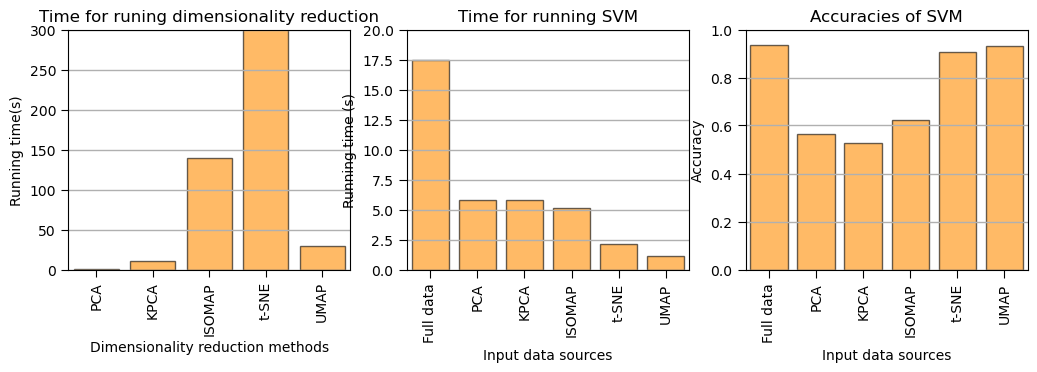

In [22]:
plt.subplot(131)                                        # plot the time for running SVM
plt.title("Time for runing dimensionality reduction")
plt.bar(range(len(DR_t)), DR_t,edgecolor = 'black',
       color="darkorange",alpha=0.6,align="center")
plt.xticks(range(len(DR_t)), method_names2,rotation=90)
plt.xlim([-0.5, len(DR_t)-0.5]); plt.ylim([0,300])
plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().tick_params(which='major',length=5); plt.gca().tick_params(which='minor', length=3)
plt.xlabel('Dimensionality reduction methods'); plt.ylabel('Running time(s)')

plt.subplot(132)                                        # plot the time for runing dimensionality reduction (from 784 dimensions to 3 dimensions)
plt.title("Time for running SVM")
plt.bar(range(SVM_at.shape[0]), SVM_at[:,1],edgecolor = 'black',
       color="darkorange",alpha=0.6,align="center")
plt.xticks(range(SVM_at.shape[0]), method_names,rotation=90)
plt.xlim([-0.5, SVM_at.shape[0]-0.5]); plt.ylim([0,20])
plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().tick_params(which='major',length=6); plt.gca().tick_params(which='minor', length=3)
plt.xlabel('Input data sources'); plt.ylabel('Running time (s)')


plt.subplot(133)                                        # plot the accuracies of SVM from different reduced datas (3 Dimensions)
plt.title("Accuracies of SVM")
plt.bar(range(SVM_at.shape[0]), SVM_at[:,0],edgecolor = 'black',
       color="darkorange",alpha=0.6,align="center")
plt.xticks(range(SVM_at.shape[0]), method_names,rotation=90)
plt.xlim([-0.5, SVM_at.shape[0]-0.5]); plt.ylim([0,1.0])
plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().tick_params(which='major',length=6); plt.gca().tick_params(which='minor', length=3)
plt.xlabel('Input data sources'); plt.ylabel('Accuracy')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=0.5, wspace=0.2, hspace=0.5)
plt.show()

Hyperparameters tunning for SVM using the Gridsearch technique (Use as you want)

In [23]:
param_grid = {'C':[0.1,1,5,10,100],'gamma':[0.005,0.001,0.005,0.01]}
model = GridSearchCV(SVC(kernel = 'rbf', class_weight = 'balanced'),param_grid)
model.fit(pca_train,y_train)
print(model.best_estimator_)
predictions = model.predict(pca_test)
print(classification_report(y_test,predictions))

### Results and Discussion

Reults:
- In this case, 9000 images of 28x28 pxiels from the MNIST dataset to demonstrate different non-linear dimensionality reduction methods. Compared with PCA, kernel PCA is the fastest non-linear dimensionality reduction method among the four while t-SNE uses most time for dimensionality reduction.
- Reduced data surely decrease the training time of SVM models. SVM using reduced datas from t-SNE and UMAP spends much less time compared with kernel PCA and isomap. The reason is that reduced datas from t-SNE and UMAP have clear boundary which can be seen in the 3D visualization. This can further improve SVM efficiency.
- SVM models, which are trained by reduced data from different dimensionality reduction methods, have different accuracies. Kernel PCA has the similar accuracy to PCA. Isomap can also not reach the accracy of the full dimensions data training model. One can improve dimensions of training data to increase accuracy of SVM models.t-SNE and UMAP have similar accuracy (0.91 and 0.93) compared with full data training model (0.94). These two methods can maintain model accuracy with only 3 dimensional data.

Discussion:
- Hyperparameter tunning is not nicely done in the dimensionality reduction and support vector machine. Before we get the results, we have run the code many times by changing hyperpaprameters to get better results. One can use gridsearching technique to improve performance of non-linear dimensionality reduction and accuracy of SVM by tunning hyperparameters.
- Non-linear dimensionality reduction methods except Kernel PCA are hard to back transform to the original data. If it is necessary to back transform the reduced data, please consider use linear reduction methods or autoencoder.

Conclusions:
- In the 3D visualization of reduced data, some clear boundaries between different digits can be seen in the isomap, t-SNE and UMAP. Kernel PCA have similar reults as PCA. In the lower dimensional data with non-linear relationship, Kernel PCA seems to work better (see [example](https://www.datatechnotes.com/2022/01/kernelpca-projection-example-in-python.html)).
- UMAP clusters the different digits quite nicely, similar to or better than t-SNE. UMAP is much faster than t-SNE. In contrast to t-SNE, UMAP does not need any Dimensionality Reduction preprocessing to perform. If data dimensions are over 50, one should do PCA to reduce data dimensions lower than 50 before conducting t-SNE. t-SNE is also a time-consuming method which takes longest running among non-linear dimensionality reduction methods.
- In the SVM models, reduced data of t-SNE and UMAP brings the highest classification accuracy which is approximately close to the accuracy of full dimensional data training model. Therefore, t-SNE and UMAP as non-linear methods can be advantageous in clustering.

### Reference
1. AA Konaté,  Pan H ,  Ma H , et al. Application of dimensionality reduction technique to improve geophysical log data classification performance in crystalline rocks. Journal of Petroleum Science & Engineering, 2015, 133:633-645.
2. Mcinnes L ,  Healy J . UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction. The Journal of Open Source Software, 2018, 3(29):861.
3. Gove R ,  Cadalzo L ,  Leiby N , et al. New guidance for using t-SNE:Alternative defaults,hyperparameter selection automation,and comparative evaluation. Visualization Meets AI, 2022, 6(2):11.
4. Maaten L ,  Postma E O ,  Herik H . Dimensionality Reduction: A Comparative Review. Journal of Machine Learning Research, 2007, 10(1).
5. Verleysen, M., Lee, J. A., Lee, J. A. (2007). Nonlinear Dimensionality Reduction. Netherlands: Springer New York.
6. Wang, J. (2012). Geometric Structure of High-Dimensional Data and Dimensionality Reduction. Germany: Higher Education Press.
7. Lee J A ,  Verleysen M . Nonlinear Dimensionality Reduction (Information Science and Statistics). 
8. Lespinats S, Colange B, Dutykh D. Nonlinear Dimensionality Reduction Techniques: A Data Structure Preservation Approach. Springer, 2022.
9. Rukshan Pramoditha (2021). 11 Dimensionality reduction techniques you should know in 2021. Website: https://towardsdatascience.com/11-dimensionality-reduction-techniques-you-should-know-in-2021-dcb9500d388b

### About Me

I am a Ph.D student of petroleum engineering at UT austin starting from August 2022, working with Professor [Carlos Torres-Verdin](https://pge.utexas.edu/facultystaff/faculty-directory/torres-verdin).My research interest lies in acoustic logging especially borehole geophysical numerical and analytical modelling. I am skilled in 3D or 2.5D FDTD ealstic wave modelling of complex media, such as elastic media, poro-elastic media and cracked porous elastic media. Now, I am working on ultrasonic wave 3D modelling and tomography.

* research area
    * Formation evaluation, acoustic logging, acoustic/ultrasonic wave propagation

I hope this was helpful,

**Feiyue Xia**

feiyue.xia@utexas.edu

#### [GitHub](https://github.com/Timothy-Xia) | [Website](https://feiyue-xia.netlify.app/) | [LinkedIn](https://www.linkedin.com/in/feiyue-xia-088947249/)

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin


***